In [1]:
import json
import pandas as pd
import re

In [2]:
with open('tioberny.txt', 'r', encoding='utf-16') as file:
    tweets = [json.loads(line) for line in file]

tioberny_tweets = pd.DataFrame(tweets)

In [3]:
with open('traficogt.txt', 'r', encoding='utf-16') as file:
    tweets = [json.loads(line) for line in file]

traficogt_tweets = pd.DataFrame(tweets)


In [4]:
print(tioberny_tweets.columns)
print(traficogt_tweets.columns)


Index(['id', 'id_str', 'url', 'date', 'user', 'lang', 'rawContent',
       'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
       'bookmarkedCount', 'conversationId', 'conversationIdStr', 'hashtags',
       'cashtags', 'mentionedUsers', 'links', 'viewCount', 'retweetedTweet',
       'quotedTweet', 'place', 'coordinates', 'inReplyToTweetId',
       'inReplyToTweetIdStr', 'inReplyToUser', 'source', 'sourceUrl',
       'sourceLabel', 'media', 'card', '_type'],
      dtype='object')
Index(['id', 'id_str', 'url', 'date', 'user', 'lang', 'rawContent',
       'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
       'bookmarkedCount', 'conversationId', 'conversationIdStr', 'hashtags',
       'cashtags', 'mentionedUsers', 'links', 'viewCount', 'retweetedTweet',
       'quotedTweet', 'place', 'coordinates', 'inReplyToTweetId',
       'inReplyToTweetIdStr', 'inReplyToUser', 'source', 'sourceUrl',
       'sourceLabel', 'media', 'card', '_type'],
      dtype='object')


Convertir a minúsculas

In [5]:
tioberny_tweets['rawContent'] = tioberny_tweets['rawContent'].str.lower()
traficogt_tweets['rawContent'] = traficogt_tweets['rawContent'].str.lower()


Quitar URLs

In [6]:
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

tioberny_tweets['rawContent'] = tioberny_tweets['rawContent'].apply(remove_urls)
traficogt_tweets['rawContent'] = traficogt_tweets['rawContent'].apply(remove_urls)


Quitar emoticones

In [7]:
def remove_emoticons(text):
    return re.sub(r'[^\w\s]', '', text)

tioberny_tweets['rawContent'] = tioberny_tweets['rawContent'].apply(remove_emoticons)
traficogt_tweets['rawContent'] = traficogt_tweets['rawContent'].apply(remove_emoticons)


Quitar signos de puntuación (exceptuando "@" y "#")

In [8]:
tioberny_tweets['rawContent'] = tioberny_tweets['rawContent'].str.replace(r'[^\w\s@#]', '', regex=True)
traficogt_tweets['rawContent'] = traficogt_tweets['rawContent'].str.replace(r'[^\w\s@#]', '', regex=True)


3.2. Extraer menciones, respuestas y retweets

In [9]:
# Crear listas para almacenar las interacciones
interactions = []

for index, row in tioberny_tweets.iterrows():
    user_id = row['user']['id_str']
    text = row['rawContent']
    
    # Extraer menciones
    mentions = re.findall(r'@(\w+)', text)  # Extraer nombres de usuario mencionados
    mentions = [mention.lower() for mention in mentions]  # Normalizar
    
    # Comprobar si es una respuesta o un retweet
    is_reply = row['inReplyToUser'] is not None
    is_retweet = row['retweetedTweet'] is not None

    interactions.append({
        'user_id': user_id,
        'mentions': mentions,
        'is_reply': is_reply,
        'is_retweet': is_retweet,
        'text': text
    })

interactions_df = pd.DataFrame(interactions)


3.3. Preprocesar datos eliminando duplicados y normalizando

In [10]:
# Eliminar duplicados
interactions_df.drop_duplicates(subset=['user_id', 'text'], inplace=True)

# Normalizar menciones
interactions_df['mentions'] = interactions_df['mentions'].apply(lambda x: [mention.lower() for mention in x])


3.4. Crear una estructura de datos eficiente para el análisis de redes

In [11]:
!pip install networkx

In [12]:
import networkx as nx

# Crear un grafo dirigido
G = nx.DiGraph()

# Agregar nodos y aristas
for _, row in interactions_df.iterrows():
    user_id = row['user_id']
    mentions = row['mentions']
    
    # Añadir nodo para el usuario
    if not G.has_node(user_id):
        G.add_node(user_id)

    # Añadir aristas por cada mención
    for mention in mentions:
        G.add_edge(user_id, mention)  # Interacción dirigida

# Convertir a una matriz de adyacencia si es necesario
adjacency_matrix = nx.to_numpy_array(G)


In [13]:
total_tweets_tioberny = len(tioberny_tweets)
total_tweets_traficogt = len(traficogt_tweets)

print(f"Número total de tweets en tioberny: {total_tweets_tioberny}")
print(f"Número total de tweets en traficogt: {total_tweets_traficogt}")


Número total de tweets en tioberny: 5019
Número total de tweets en traficogt: 5605


In [14]:
# Obtener IDs de usuario de manera correcta
unique_users_tioberny = tioberny_tweets['user'].apply(lambda x: x['id_str']).nunique()
unique_users_traficogt = traficogt_tweets['user'].apply(lambda x: x['id_str']).nunique()

print(f"Número de usuarios únicos en tioberny: {unique_users_tioberny}")
print(f"Número de usuarios únicos en traficogt: {unique_users_traficogt}")



Número de usuarios únicos en tioberny: 2620
Número de usuarios únicos en traficogt: 2072


In [15]:
total_mentions_tioberny = interactions_df['mentions'].explode().nunique()
total_mentions_traficogt = interactions_df['mentions'].explode().nunique()

print(f"Número total de menciones en tioberny: {total_mentions_tioberny}")
print(f"Número total de menciones en traficogt: {total_mentions_traficogt}")


Número total de menciones en tioberny: 0
Número total de menciones en traficogt: 0


In [16]:
hashtags_tioberny = tioberny_tweets['hashtags'].explode().value_counts()
hashtags_traficogt = traficogt_tweets['hashtags'].explode().value_counts()

print("Hashtags más frecuentes en tioberny:")
print(hashtags_tioberny.head(10))

print("Hashtags más frecuentes en traficogt:")
print(hashtags_traficogt.head(10))


Hashtags más frecuentes en tioberny:
hashtags
URGENTE                         26
GuatemalaSaleAdelante           25
MinfinSaleAdelante              17
Guatemala                       15
Presupuesto2025                 14
UnPresupuestoParaLaPoblación    13
EnElPaísDCA                     12
NacionalesAGN                    8
ElEstor                          7
XelaNews                         7
Name: count, dtype: int64
Hashtags más frecuentes en traficogt:
hashtags
AHORA                     18
AhoraLH                   18
Guatemala                 16
RenuncienGolpistas        13
URGENTE                   10
guatemala                  9
ParoNacionalIndefinido     9
ParoNacionaIndefinido      8
Ahora                      8
LaHoraDeActualizarnos      8
Name: count, dtype: int64


In [17]:
!pip install wordcloud

In [18]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

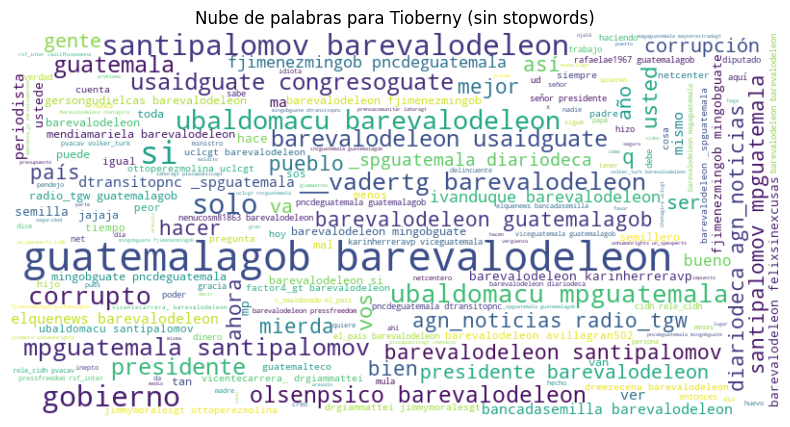

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# Obtener stopwords en español
stop_words = set(stopwords.words('spanish'))

# Unir todos los textos para crear la nube, excluyendo las stopwords
text_tioberny = ' '.join(tioberny_tweets['rawContent'])
text_tioberny_filtered = ' '.join([word for word in text_tioberny.split() if word not in stop_words])

# Crear la nube de palabras
wordcloud_tioberny = WordCloud(width=800, height=400, background_color='white').generate(text_tioberny_filtered)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_tioberny, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras para Tioberny (sin stopwords)')
plt.show()


## Inciso 5

In [20]:

lol = tioberny_tweets['mentionedUsers']

lol[0]

[{'id': 23664866,
  'id_str': '23664866',
  'username': 'usembassyguate',
  'displayname': 'US Embassy Guatemala',
  '_type': 'snscrape.modules.twitter.UserRef'},
 {'id': 1001171061831020545,
  'id_str': '1001171061831020545',
  'username': '48CantonesToto',
  'displayname': '48 Cantones Oficial',
  '_type': 'snscrape.modules.twitter.UserRef'},
 {'id': 262691982,
  'id_str': '262691982',
  'username': 'USAIDGuate',
  'displayname': 'USAID Guatemala',
  '_type': 'snscrape.modules.twitter.UserRef'},
 {'id': 1362391326,
  'id_str': '1362391326',
  'username': 'UEGuatemala',
  'displayname': 'Unión Europea en Guatemala',
  '_type': 'snscrape.modules.twitter.UserRef'},
 {'id': 945378369818058752,
  'id_str': '945378369818058752',
  'username': 'BArevalodeLeon',
  'displayname': 'Bernardo Arévalo',
  '_type': 'snscrape.modules.twitter.UserRef'}]

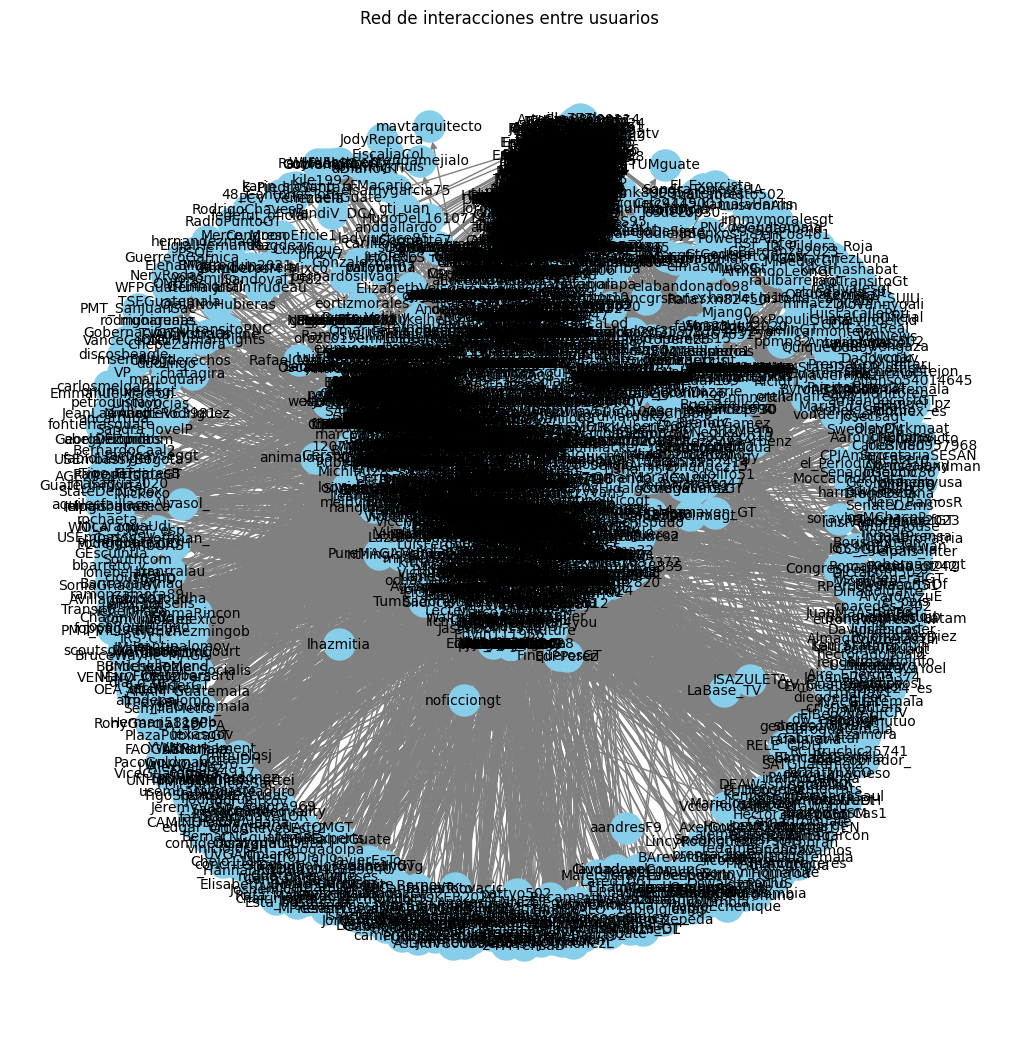

In [21]:
import networkx as nx
import matplotlib.pyplot as plt


# Crear un grafo dirigido
G = nx.DiGraph()

# Añadir nodos y aristas basados en las interacciones de los usuarios
for index, row in tioberny_tweets.iterrows():
    user = row['user']['username']  # Extraer el nombre de usuario del campo JSON
    mentioned_users = row['mentionedUsers']
    
    if mentioned_users:
        for mentioned_user in mentioned_users:
            mentioned_username = mentioned_user['username']  # Extraer el nombre de usuario mencionado
            G.add_edge(user, mentioned_username)  # Añadir una arista entre el usuario y el mencionado

# Visualización del grafo
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_color="black", edge_color="gray")
plt.title('Red de interacciones entre usuarios')
plt.show()


In [22]:
# Nodos más conectados (usuarios con más interacciones)
degree_centrality = nx.degree_centrality(G)
top_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]  # Top 10 nodos más conectados
print("Usuarios más conectados:")

for node, degree in top_nodes:
    print(f"  - {node}: {degree:.2f}")



Usuarios más conectados:
  - BArevalodeLeon: 0.81
  - GuatemalaGob: 0.20
  - UbaldoMacu: 0.13
  - santipalomov: 0.12
  - MPguatemala: 0.11
  - FJimenezmingob: 0.09
  - __VaderTG: 0.08
  - CongresoGuate: 0.07
  - mingobguate: 0.07
  - USAIDGuate: 0.06


In [23]:
# Densidad de la red
density = nx.density(G)
print("Densidad de la red:", density)

# Obtener el componente fuertemente conexo más grande del grafo
largest_scc = max(nx.strongly_connected_components(G), key=len)
subgraph = G.subgraph(largest_scc)

# Calcular el diámetro solo en el componente conexo más grande
if len(largest_scc) > 1:
    diameter = nx.diameter(subgraph.to_undirected())
    print("Diámetro de la red (componente conexo más grande):", diameter)
else:
    print("No se puede calcular el diámetro en un subgrafo de un solo nodo.")

# Coeficiente de agrupamiento (promedio) en todo el grafo
clustering_coefficient = nx.average_clustering(G.to_undirected())
print("Coeficiente de agrupamiento promedio:", clustering_coefficient)


Densidad de la red: 0.0012714250592210398
Diámetro de la red (componente conexo más grande): 5
Coeficiente de agrupamiento promedio: 0.3729830122015355


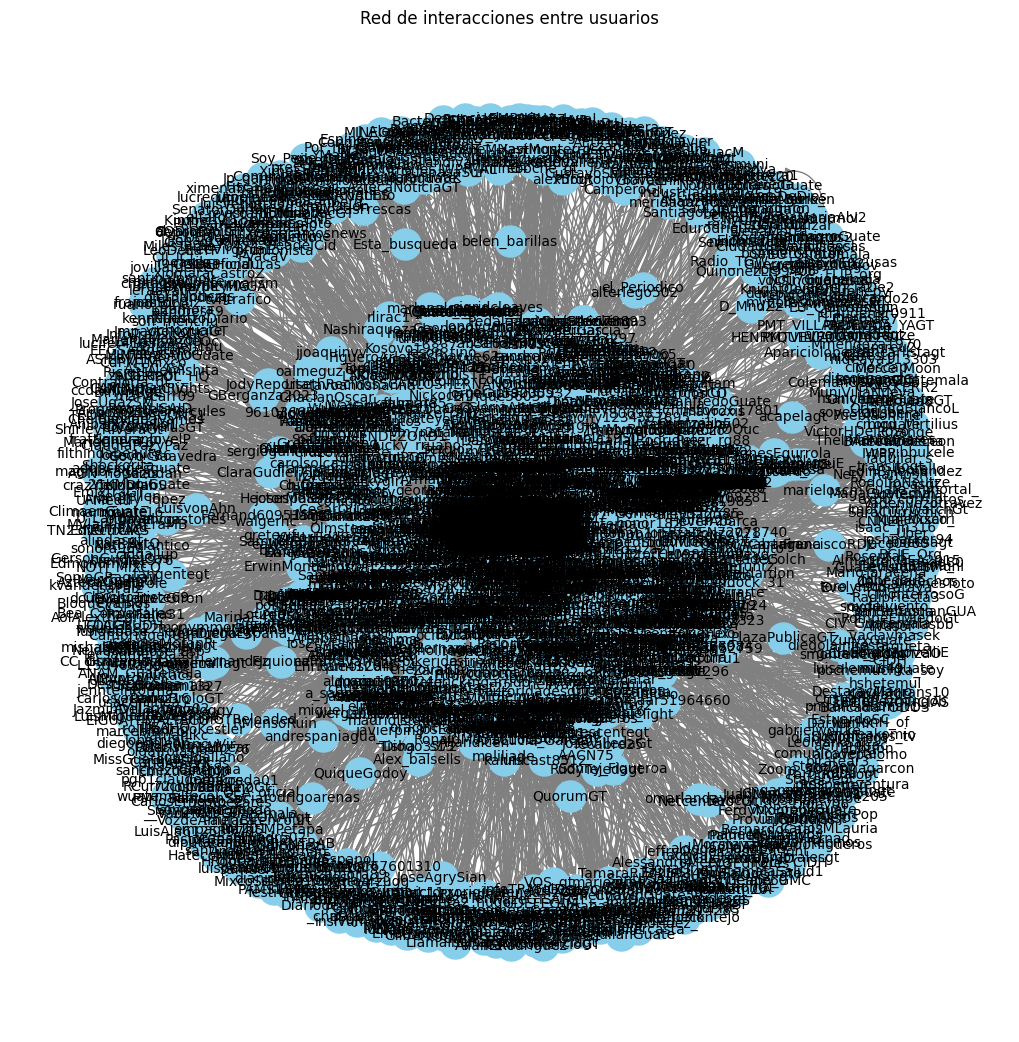

In [24]:

# Crear un grafo dirigido
G_trafico = nx.DiGraph()

# Añadir nodos y aristas basados en las interacciones de los usuarios
for index, row in traficogt_tweets.iterrows():
    user = row['user']['username']  # Extraer el nombre de usuario del campo JSON
    mentioned_users = row['mentionedUsers']
    
    if mentioned_users:
        for mentioned_user in mentioned_users:
            mentioned_username = mentioned_user['username']  # Extraer el nombre de usuario mencionado
            G_trafico.add_edge(user, mentioned_username)  # Añadir una arista entre el usuario y el mencionado

# Visualización del grafo
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_trafico)
nx.draw(G_trafico, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_color="black", edge_color="gray")
plt.title('Red de interacciones entre usuarios')
plt.show()


In [25]:
# Nodos más conectados (usuarios con más interacciones)
degree_centrality = nx.degree_centrality(G_trafico)
top_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]  # Top 10 nodos más conectados
print("Usuarios más conectados:")

for node, degree in top_nodes:
    print(f"  - {node}: {degree:.2f}")



Usuarios más conectados:
  - traficogt: 0.71
  - BArevalodeLeon: 0.12
  - DrGiammattei: 0.05
  - PrensaComunitar: 0.05
  - mildred_gaitan: 0.05
  - mmendoza_GT: 0.04
  - batallonjalapa: 0.04
  - MPguatemala: 0.04
  - amilcarmontejo: 0.03
  - lahoragt: 0.03


In [26]:
# Densidad de la red
density = nx.density(G_trafico)
print("Densidad de la red:", density)

# Obtener el componente fuertemente conexo más grande del grafo
largest_scc = max(nx.strongly_connected_components(G_trafico), key=len)
subgraph = G_trafico.subgraph(largest_scc)

# Calcular el diámetro solo en el componente conexo más grande
if len(largest_scc) > 1:
    diameter = nx.diameter(subgraph.to_undirected())
    print("Diámetro de la red (componente conexo más grande):", diameter)
else:
    print("No se puede calcular el diámetro en un subgrafo de un solo nodo.")

# Coeficiente de agrupamiento (promedio) en todo el grafo
clustering_coefficient = nx.average_clustering(G_trafico.to_undirected())
print("Coeficiente de agrupamiento promedio:", clustering_coefficient)


Densidad de la red: 0.0009929578225998227
Diámetro de la red (componente conexo más grande): 2
Coeficiente de agrupamiento promedio: 0.23393730512199887


## Inciso 6

In [27]:
!pip install networkx python-louvain

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9404 sha256=3065394cd9659315f1b6d2b6ecdd3a713c091430be74a4a0ddd6705cd69fe5a8
  Stored in directory: c:\users\acer\appdata\local\pip\cache\wheels\d0\b0\d7\6dd26c3817810fa379088eaeb755a01d9a2a411c37632079d1
Successfully built python-louvain


In [55]:
import pandas as pd
import community as community_louvain

# Inicializamos una lista para las interacciones
interacciones = []

# Procesamos las menciones
for index, row in tioberny_tweets.iterrows():
    if row['mentionedUsers']:
        for mention in row['mentionedUsers']:
            interacciones.append({'source': row['user']['id_str'], 'target': mention['id_str'], 'tipo': 'mention'})

for index, row in traficogt_tweets.iterrows():
    if row['mentionedUsers']:
        for mention in row['mentionedUsers']:
            interacciones.append({'source': row['user']['id_str'], 'target': mention['id_str'], 'tipo': 'mention'})

# Procesamos las respuestas
for index, row in tioberny_tweets.iterrows():
    if row['inReplyToUser']:
        interacciones.append({'source': row['user']['id_str'], 'target': row['inReplyToUser']['id_str'], 'tipo': 'reply'})

for index, row in traficogt_tweets.iterrows():
    if row['inReplyToUser']:
        interacciones.append({'source': row['user']['id_str'], 'target': row['inReplyToUser']['id_str'], 'tipo': 'reply'})

# Procesamos los retweets
for index, row in tioberny_tweets.iterrows():
    if row['retweetedTweet']:
        interacciones.append({'source': row['user']['id_str'], 'target': row['retweetedTweet']['user']['id_str'], 'tipo': 'retweet'})

for index, row in traficogt_tweets.iterrows():
    if row['retweetedTweet']:
        interacciones.append({'source': row['user']['id_str'], 'target': row['retweetedTweet']['user']['id_str'], 'tipo': 'retweet'})

# Crear un DataFrame con las interacciones
interacciones_df = pd.DataFrame(interacciones)


In [56]:
# Crear un grafo dirigido con NetworkX
G = nx.from_pandas_edgelist(interacciones_df, 'source', 'target', create_using=nx.DiGraph())

# Aplicar el algoritmo de Louvain para detección de comunidades
particiones = community_louvain.best_partition(G.to_undirected())  # Convertimos a no dirigido


In [57]:
import networkx as nx
import community as community_louvain  # Louvain method for community detection
import matplotlib.pyplot as plt
from collections import Counter

# Crear un grafo dirigido con NetworkX desde el DataFrame de interacciones
G = nx.from_pandas_edgelist(interacciones_df, 'source', 'target', create_using=nx.DiGraph())

# Convertir el grafo a no dirigido para aplicar el algoritmo de Louvain
G_undirected = G.to_undirected()

# Aplicar el algoritmo de Louvain para detección de comunidades
particiones = community_louvain.best_partition(G_undirected)

# Agregar las particiones (comunidades) como un atributo del grafo
nx.set_node_attributes(G, particiones, 'comunidad')

# Obtener las 3 comunidades más grandes
contar_comunidades = Counter(particiones.values())
comunidades_mas_grandes = contar_comunidades.most_common(3)

# Imprimir las 3 comunidades más grandes con los nodos correspondientes y sus temas principales
for comunidad, tamaño in comunidades_mas_grandes:
    usuarios_comunidad = [nodo for nodo, part in particiones.items() if part == comunidad]
    print(f"Comunidad {comunidad} (tamaño: {tamaño}): {usuarios_comunidad}")
    
    # Filtrar los tweets de los usuarios en la comunidad actual
    tweets_comunidad = interacciones_df[interacciones_df['source'].isin(usuarios_comunidad)]
    
    # Analizar temas principales de conversación (por ejemplo, hashtags más usados)
    if 'hashtags' in tweets_comunidad.columns:
        temas_principales = tweets_comunidad['hashtags'].explode().value_counts().head(5)
        print(f"Temas principales en la comunidad {comunidad}: {temas_principales}")
    else:
        print(f"No se encontraron hashtags para la comunidad {comunidad}")


Comunidad 2 (tamaño: 1319): ['1001171061831020545', '1287890605671055361', '205009534', '783345301256073216', '3293316095', '154534634', '163221131', '85436367', '769406971212693504', '221932544', '2864292915', '1164198779869892608', '134860773', '49880530', '1590369075632295937', '1699546244', '1767300056569315328', '1586352378290360320', '1696347063397609472', '1309256339512864769', '951616776193871874', '1455885276', '1789432632301780993', '102728856', '707086237753090048', '47940875', '2163358477', '907246319781195776', '3482352267', '968884641951346689', '1428752769498877962', '953849637470920704', '1133845904430125056', '1585099133106491392', '8381682', '976875408', '151341344', '115133899', '93938886', '128681078', '603973689', '1815652744520478720', '1539335983476490243', '879376886253715456', '1192237164630859776', '1057459767571030021', '1563721134000013314', '815379182', '736952671', '4909691359', '425425943', '1743399783203586048', '1659949726618497029', '2340281225', '1617

C:\Users\acer\AppData\Local\Temp\ipykernel_7296\2394036597.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(set(particiones.values())))


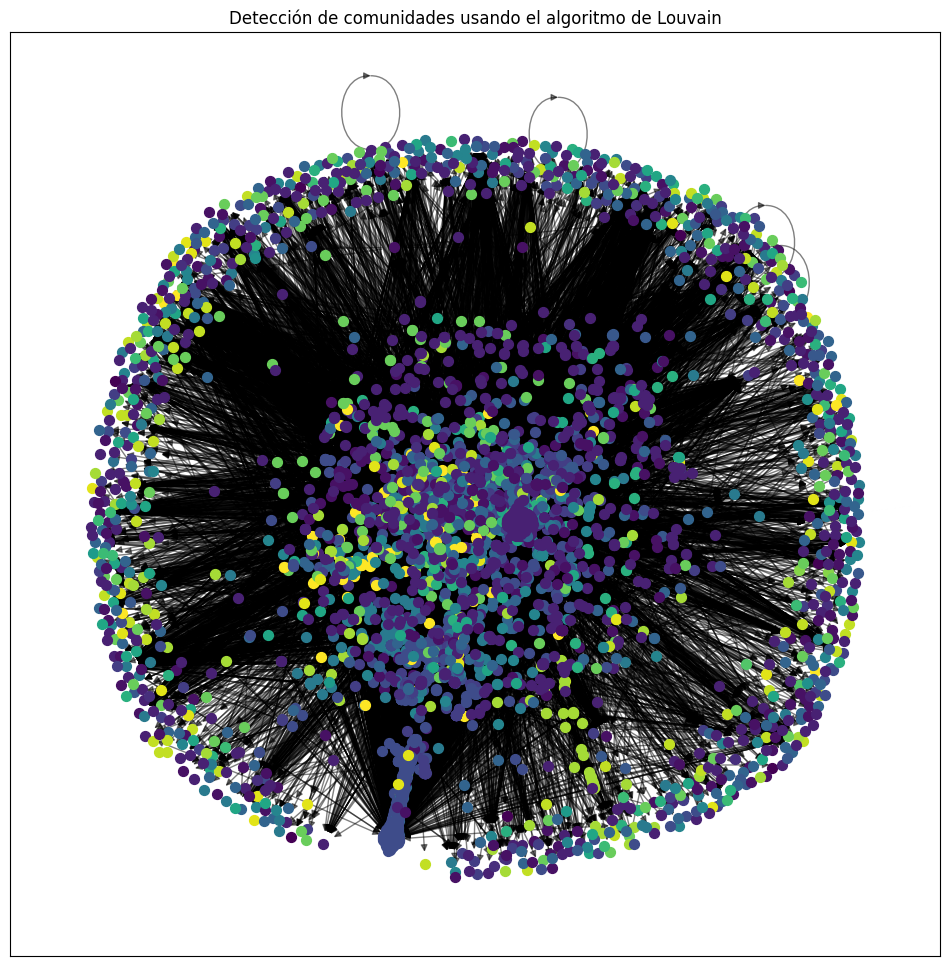

In [58]:
# Definir una paleta de colores para las comunidades
import matplotlib.cm as cm
import numpy as np

# Dibujar el grafo con colores según las comunidades
plt.figure(figsize=(12, 12))

# Obtener un layout para los nodos
pos = nx.spring_layout(G)

# Asignar colores a las comunidades
cmap = cm.get_cmap('viridis', len(set(particiones.values())))

# Dibujar los nodos con color según su comunidad
for node, comunidad in particiones.items():
    nx.draw_networkx_nodes(G, pos, [node], node_size=50, node_color=[cmap(comunidad)])

# Dibujar los bordes
nx.draw_networkx_edges(G, pos, alpha=0.5)

plt.title('Detección de comunidades usando el algoritmo de Louvain')
plt.show()


In [60]:
# Contar los usuarios en cada comunidad
for comunidad, tamaño in comunidades_mas_grandes:
    print(f"Comunidad {comunidad} tiene {tamaño} usuarios.")

# Filtrar los tweets y menciones más frecuentes en cada comunidad
for comunidad, _ in comunidades_mas_grandes:
    usuarios_comunidad = [n for n, c in particiones.items() if c == comunidad]
    tweets_comunidad = interacciones_df[interacciones_df['source'].isin(usuarios_comunidad)]
    
    # Analizar temas principales de conversación (por ejemplo, hashtags más usados)
    if 'hashtags' in tweets_comunidad.columns:
        # Si los hashtags están en listas, usamos explode
        temas_principales = tweets_comunidad['hashtags'].explode().value_counts().head(5)
        print(f"Temas principales en la comunidad {comunidad}:")
        print(temas_principales)
    else:
        print(f"No se encontraron hashtags para la comunidad {comunidad}.")



Comunidad 2 tiene 1319 usuarios.
Comunidad 5 tiene 1014 usuarios.
Comunidad 4 tiene 476 usuarios.
No se encontraron hashtags para la comunidad 2.
No se encontraron hashtags para la comunidad 5.
No se encontraron hashtags para la comunidad 4.


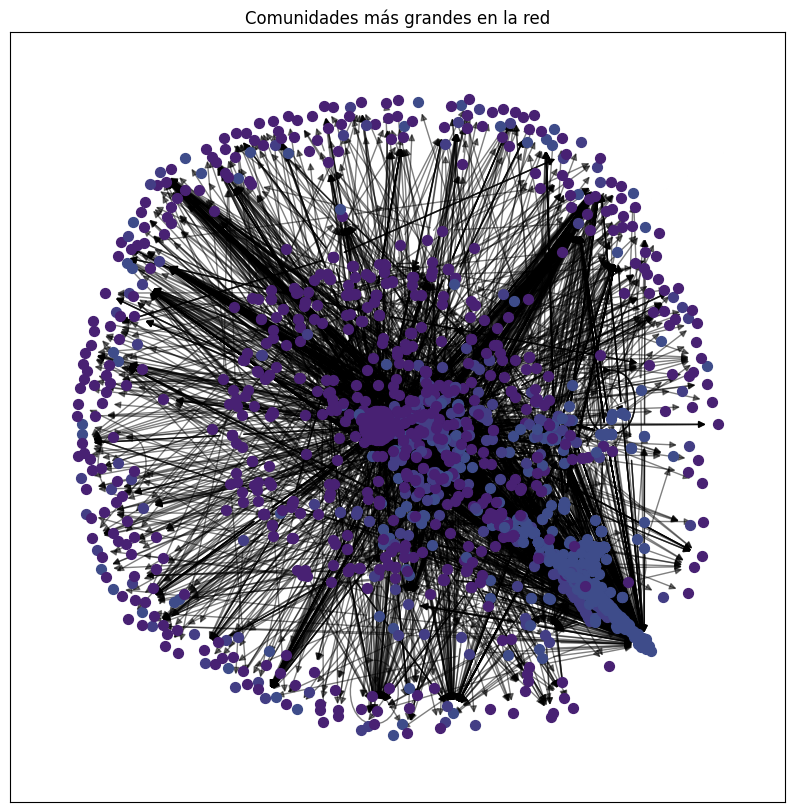

In [61]:
# Filtrar las interacciones entre las 3 comunidades más grandes
usuarios_top_comunidades = [n for n, c in particiones.items() if c in [com[0] for com in comunidades_mas_grandes]]
subgrafo_top_comunidades = G.subgraph(usuarios_top_comunidades)

# Dibujar el subgrafo
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(subgrafo_top_comunidades)

# Asignar colores a las comunidades
for node, comunidad in particiones.items():
    if node in subgrafo_top_comunidades:
        nx.draw_networkx_nodes(subgrafo_top_comunidades, pos, [node], node_size=50, node_color=[cmap(comunidad)])

nx.draw_networkx_edges(subgrafo_top_comunidades, pos, alpha=0.5)
plt.title('Comunidades más grandes en la red')
plt.show()


In [48]:
import networkx as nx

# Crear el grafo dirigido desde el DataFrame de interacciones (si no lo has hecho ya)
G = nx.from_pandas_edgelist(interacciones_df, 'source', 'target', create_using=nx.DiGraph())

# 1. Centralidad de grado
degree_centrality = nx.degree_centrality(G)

# 2. Centralidad de intermediación (Betweenness Centrality)
betweenness_centrality = nx.betweenness_centrality(G)

# 3. Centralidad de cercanía (Closeness Centrality)
closeness_centrality = nx.closeness_centrality(G)

# Convertir los resultados a DataFrames para facilitar el análisis
import pandas as pd

centralidad_df = pd.DataFrame({
    'Usuario': list(degree_centrality.keys()),
    'Centralidad_Grado': list(degree_centrality.values()),
    'Centralidad_Intermediación': list(betweenness_centrality.values()),
    'Centralidad_Cercanía': list(closeness_centrality.values())
})

# Ordenar por cada métrica y mostrar los usuarios más influyentes
print("Top 5 usuarios por centralidad de grado:")
print(centralidad_df.sort_values(by='Centralidad_Grado', ascending=False).head(5))

print("\nTop 5 usuarios por centralidad de intermediación:")
print(centralidad_df.sort_values(by='Centralidad_Intermediación', ascending=False).head(5))

print("\nTop 5 usuarios por centralidad de cercanía:")
print(centralidad_df.sort_values(by='Centralidad_Cercanía', ascending=False).head(5))


Top 5 usuarios por centralidad de grado:
                 Usuario  Centralidad_Grado  Centralidad_Intermediación  \
5     945378369818058752           0.528192                    0.000000   
964             93938886           0.375702                    0.027994   
21             495102115           0.127107                    0.000428   
59             609174347           0.084092                    0.000164   
64   1787943453344595968           0.081573                    0.028773   

     Centralidad_Cercanía  
5                0.590396  
964              0.385362  
21               0.327033  
59               0.286003  
64               0.197649  

Top 5 usuarios por centralidad de intermediación:
                  Usuario  Centralidad_Grado  Centralidad_Intermediación  \
64    1787943453344595968           0.081573                    0.028773   
964              93938886           0.375702                    0.027994   
29    1299426548638978049           0.009107                 